# Speaker Verification on Synthesized Speech


## Load the Data

The `dataset.py` module handles data loading and preprocessing for the speaker verification task. Its key functionalities include:

- **Loading Mapping and Metadata**: It reads `mapping.json` to load the speaker-to-ID mapping and `metadata.json` to load metadata about the speakers and their utterances.

- **Building the Data List**: It creates a list of samples where each sample consists of the feature path (pointing to a preprocessed mel-spectrogram) and the corresponding speaker label.

- **Implementing `__len__` and `__getitem__`**:

  - `__len__` returns the total number of samples.

  - `__getitem__` loads a mel-spectrogram using `torch.load()` from the given file path. If the mel-spectrogram is longer than a predefined segment length, it randomly selects a segment of that length; otherwise, it uses the entire sequence. The function also converts the mel data and speaker label into torch tensors.

  - **Providing Speaker Information**: The method  `get_speaker_number()` returns the total number of unique speakers in the dataset.

The `data_loader.py` module is responsible for creating DataLoader objects that facilitate batching and efficient data loading during training and validation. Its main components include:

- `collate_batch`: takes a list of samples (each a tuple of `(mel, speaker)`) and performs the following:

  - Uses `pad_sequence` to pad the mel-spectrograms in the batch so that all have the same length.

  - Converts speaker labels into a LongTensor suitable for loss computation.

  - This function ensures that each batch is uniformly shaped, which is essential when dealing with sequences of varying lengths.

- `get_dataloader`:

  - Instantiates `myDataset` using the provided data directory.

  - Retrieves the total number of speakers using the `dataset.py`'s `get_speaker_number` method.

  - Splits the dataset into training (90%) and validation (10%) subsets using `random_split`.

  - Creates two DataLoader objects (one for training and one for validation) with the specified batch size, number of workers, and the custom collate function.

In [1]:
from data_loader import get_dataloader

data_dir = "./Dataset"    # Path where your Dataset folder is located
batch_size = 32           # Set your desired batch size
n_workers = 4             # Number of subprocesses for data loading

train_loader, valid_loader, speaker_num = get_dataloader(data_dir, batch_size, n_workers)

print("Data loaded!")
print(f"Number of speakers: {speaker_num}")

Data loaded!
Number of speakers: 600


## EDA (Exploratory Data Analysis)

### Terminologies

- **Utterance**: a continuous segment of speech (often a sentence or phrase) that serves as an input unit in speech processing.

- **Mel-spectrogram**: a time-frequency representation of an audio signal with the frequency axis converted to the mel scale, aligning with human auditory perception.

- **Bin**: a discrete interval of frequency obtained by dividing a continuous frequency range. In a mel-spectrogram, each bin corresponds to a specific frequency range and holds the energy or intensity information for that segment.
  
- **Frequency**: the number of oscillations or cycles per second of a signal, measured in Hertz (Hz). In audio, it determines the pitch of the sound—higher frequencies correspond to higher pitches and lower frequencies to lower pitches. Frequency information is crucial for analyzing the spectral characteristics of audio signals.

### Statistical Information of Mel-Spectrograms

In [5]:
import numpy as np
from dataset import myDataset

dataset = myDataset("./Dataset")
all_means = []
all_stds = []

# Iterate through a subset (or all) of the dataset to compute statistics
for i in range(len(dataset)):
    mel, _ = dataset[i]
    all_means.append(mel.mean().item())
    all_stds.append(mel.std().item())

print("Overall Mel Mean:", np.mean(all_means))
print("Overall Mel Std:", np.mean(all_stds))

Overall Mel Mean: -1.942853941384587
Overall Mel Std: 3.0704081893173387


The computed overall mel mean is approximately -1.94, indicating that the mel-spectrogram values are centered slightly below zero. This negative mean is expected due to the logarithmic transformation applied during mel feature extraction. 

The standard deviation of about 3.07 suggests a moderate spread in the mel values across the dataset, capturing both low-energy and high-energy regions. Overall, these statistics provide a useful baseline for normalization and further feature processing in our speaker verification pipeline.

### Mel-spectrogram Sample

Mel shape: torch.Size([128, 40])
Speaker ID: 436


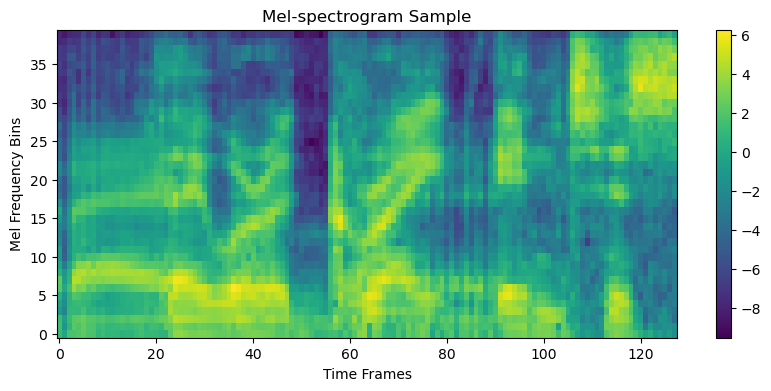

In [ ]:
from dataset import myDataset
import torch

# Create an instance of the dataset
dataset = myDataset(data_dir)

# Get a sample (mel spectrogram and speaker label)
mel, speaker = dataset[0]
print("Mel shape:", mel.shape)
print("Speaker ID:", speaker.item())

# Visualize the mel-spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel.T, aspect="auto", origin="lower")
plt.colorbar()
plt.title("Mel-spectrogram Sample")
plt.xlabel("Time Frames")
plt.ylabel("Mel Frequency Bins")
plt.show()

- What it shows: A single mel-spectrogram for one utterance (time frames on the x-axis, frequency bins on the y-axis).

- Observation: We can see distinct bands and variations in amplitude (color intensity) over time. Speech typically has these time‐frequency patterns, with energy concentrated at certain frequencies.

- Implication: Visually confirms that the data looks like typical speech mel-spectrograms. Any anomalies (e.g., silent segments, noise) would also appear in such visualizations, so it’s a quick check of data quality.

### Overview of Metadata Information

In [7]:
import json
from pathlib import Path

data_dir = "./Dataset"
with open(Path(data_dir) / "metadata.json") as f:
    metadata = json.load(f)["speakers"]

print("Total number of speakers:", len(metadata))
# Display metadata for the first 5 speakers
for speaker, utterances in list(metadata.items())[:5]:
    print(f"Speaker {speaker} has {len(utterances)} utterances")

Total number of speakers: 600
Speaker id03074 has 101 utterances
Speaker id05623 has 91 utterances
Speaker id06406 has 84 utterances
Speaker id01014 has 107 utterances
Speaker id02426 has 103 utterances


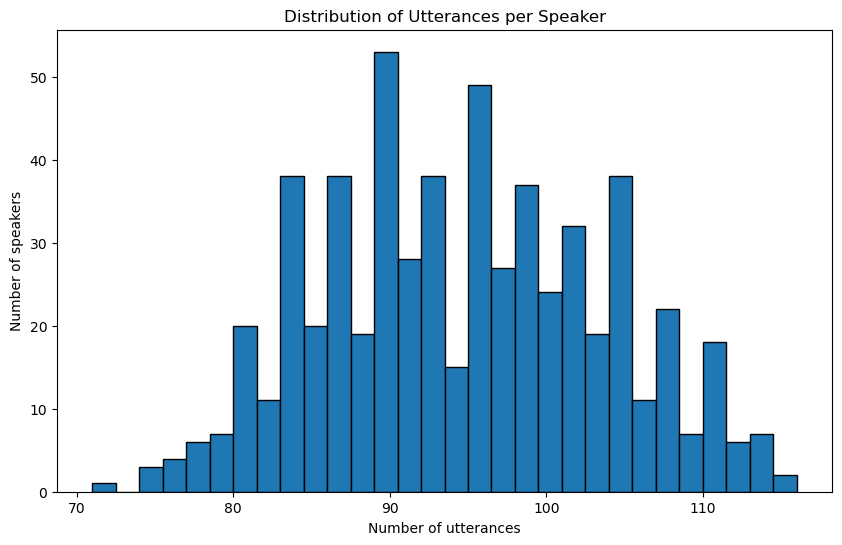

In [2]:
import os
import json
import matplotlib.pyplot as plt

data_dir = "./Dataset"

# Load mapping and metadata files
with open(os.path.join(data_dir, "mapping.json")) as f:
    mapping = json.load(f)
with open(os.path.join(data_dir, "metadata.json")) as f:
    metadata = json.load(f)["speakers"]

# Count the number of utterances per speaker
utterance_counts = {speaker: len(utterances) for speaker, utterances in metadata.items()}

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(list(utterance_counts.values()), bins=30, edgecolor="k")
plt.xlabel("Number of utterances")
plt.ylabel("Number of speakers")
plt.title("Distribution of Utterances per Speaker")
plt.show()


- What it shows: This histogram shows how many utterances each speaker has.

- Observation: Most speakers have between about 70 to 110 utterances, with a peak around 90. This indicates that, while there’s some variation, the dataset is relatively balanced: no single speaker has an overwhelmingly large or small number of utterances.

- Implication: A reasonably balanced distribution of utterances per speaker is good for training speaker‐recognition models, since each speaker is well‐represented without massive imbalance.

### Average Energy Distribution Across Frequency Bins

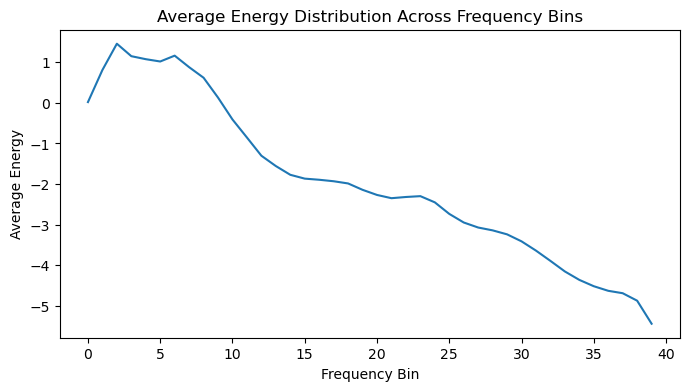

In [6]:
import matplotlib.pyplot as plt
import torch
from dataset import myDataset

dataset = myDataset("./Dataset")
sum_energy = None
count = 0

# Calculate average energy per frequency bin across the dataset
for i in range(len(dataset)):
    mel, _ = dataset[i]  # mel shape: (segment_len, num_bins)
    avg_per_sample = mel.mean(dim=0)  # Average over time frames for each frequency bin
    if sum_energy is None:
        sum_energy = avg_per_sample
    else:
        sum_energy += avg_per_sample
    count += 1

avg_energy = sum_energy / count

plt.figure(figsize=(8, 4))
plt.plot(avg_energy.numpy())
plt.xlabel("Frequency Bin")
plt.ylabel("Average Energy")
plt.title("Average Energy Distribution Across Frequency Bins")
plt.show()

The plot shows that lower frequency bins (toward the left) tend to have higher average energy, while higher bins (toward the right) generally have lower energy. This is a common pattern in speech signals, where most of the spectral energy is concentrated in the lower frequency range. From a speaker verification perspective, these observations suggest that focusing on lower to mid frequency bins could be more informative, although the higher bins may still capture certain fine-grained details important for distinguishing synthetic vs. real speech.

### Distribution of Raw Mel-Spectrogram Lengths

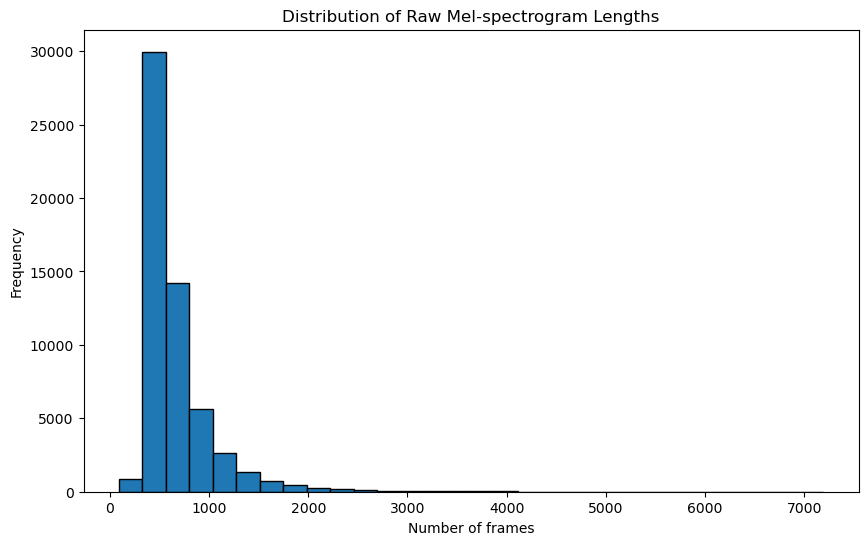

In [4]:
import torch

# List to store original lengths
mel_lengths = []

# Iterate over a subset of the dataset (or all, if desired)
for idx in range(len(dataset)):
    feat_path, _ = dataset.data[idx]
    # Load the raw mel (without segmentation)
    mel_raw = torch.load(os.path.join(data_dir, feat_path))
    mel_lengths.append(len(mel_raw))

plt.figure(figsize=(10, 6))
plt.hist(mel_lengths, bins=30, edgecolor="k")
plt.xlabel("Number of frames")
plt.ylabel("Frequency")
plt.title("Distribution of Raw Mel-spectrogram Lengths")
plt.show()

- What it shows: The number of frames in each utterance before any segmentation.

- Observation: Most utterances are under 1,000 frames, but there’s a long tail extending up to around 7,000 frames. That means some utterances are significantly longer than others.

- Implication: The variable length could impact model training if we do not segment or pad uniformly. Since we segment to a fixed length (e.g., 128 frames) in our `myDataset`, this histogram explains why some utterances are clipped, while others remain short.

## Data Processing

To enhance the robustness of our speaker verification model, we have integrated a simple **random noise injection** step into our training workflow. Specifically, for each batch of mel-spectrograms, we apply a function (`add_random_noise`) that adds Gaussian noise scaled by a hyperparameter (`noise_level`) to the original signal. This approach exposes our model to variations in input audio, helping it generalize better to real-world conditions, such as background noise or microphone variations.

We use this augmentation by calling the function on the training set **inside the training loop** (i.e., after loading a batch of mel-spectrograms and before passing them into the model). By doing so, we ensure that our model sees slightly perturbed versions of the same audio samples at different iterations, reducing the chance of overfitting to the exact distribution of the training set.

## Model Training

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

In [9]:
# 1. Import the augmentation function
from augmentation import add_random_noise

# 2. Import the CNN model
from speaker_cnn import SimpleCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Initialize the model
model = SimpleCNN(num_speakers=speaker_num, input_dim=40).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
# Define our training and validation loops
def train_one_epoch(model, dataloader, optimizer, criterion, device, noise_level=0.01):
    model.train()
    running_loss = 0.0
    for mel, spk in dataloader:
        mel, spk = mel.to(device), spk.to(device)
        
        # Use the augmentation here
        mel = add_random_noise(mel, noise_level=noise_level)
        
        optimizer.zero_grad()
        outputs = model(mel)
        loss = criterion(outputs, spk)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * mel.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for mel, spk in dataloader:
            mel, spk = mel.to(device), spk.to(device)
            outputs = model(mel)
            loss = criterion(outputs, spk)
            running_loss += loss.item() * mel.size(0)
    val_loss = running_loss / len(dataloader.dataset)
    return val_loss

In [ ]:
num_epochs = 2
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss   = validate_one_epoch(model, valid_loader, criterion, device)
    
    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

[Epoch 1/2] Train Loss: 5.8378 | Val Loss: 5.2836


In [ ]:
# save the model
torch.save(model.state_dict(), "simple_cnn_speaker_verification.pth")
print("Training complete. Model saved.")